KHAI BÁO THƯ VIỆN

In [21]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report,roc_curve, auc
import joblib
from sklearn.svm import SVC
import torch
from sklearn.decomposition import PCA


In [22]:
seed = 42

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cuda


LOAD DATA

In [23]:
x_train_scaled_loaded = joblib.load('../data/binary_class/x_train_scaled_binary_class.pkl')
x_test_scaled_loaded  = joblib.load('../data/binary_class/x_test_scaled_binary_class.pkl')
y_train_loaded        = joblib.load('../data/binary_class/y_train_binary_class.pkl')
y_test_loaded         = joblib.load('../data/binary_class/y_test_binary_class.pkl')

In [24]:
x_train_scaled_loaded = x_train_scaled_loaded.to_numpy()
x_test_scaled_loaded  = x_test_scaled_loaded.to_numpy() 
y_train_loaded = y_train_loaded.to_numpy()
y_test_loaded  = y_test_loaded.to_numpy()

In [25]:
print (x_train_scaled_loaded.shape)
print (y_train_loaded.shape)

print (x_test_scaled_loaded.shape)
print (y_test_loaded.shape)

(3353, 27)
(3353,)
(839, 27)
(839,)


SVM without hyperparameter

In [26]:
svm_model1 = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model1.fit(x_train_scaled_loaded, y_train_loaded)
svm_model1.score(x_test_scaled_loaded , y_test_loaded)

0.8176400476758046

In [27]:
y_pred = svm_model1.predict(x_test_scaled_loaded)
precision = precision_score(y_test_loaded, y_pred)
recall = recall_score(y_test_loaded, y_pred)
f1 = f1_score(y_test_loaded, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.7558
Recall:    0.9379
F1-score:  0.8371


DÙNG OPTUNA ĐỂ TÌM RA BỘ SIÊU THAM SỐ

In [28]:
def objective(trial):
    """
    Hàm mục tiêu cho Optuna để tối ưu hóa các siêu tham số của mô hình SVC.
    
    Tham số:
        trial: Đối tượng trial của Optuna dùng để đề xuất các giá trị siêu tham số.
    
    Trả về:
        Giá trị trung bình độ chính xác (accuracy) từ cross-validation với 3 folds.
    """
    # Đề xuất giá trị cho các siêu tham số của SVC
    C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])  # Lựa chọn kernel
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto', 0.01, 0.001])  # Tham số gamma cho kernel
    degree = trial.suggest_int('degree', 2, 3)  # Bậc của đa thức nếu kernel='poly'
    
    # Khởi tạo mô hình SVC với các siêu tham số được đề xuất
    model = SVC(
        C=C, 
        kernel=kernel, 
        gamma=gamma, 
        degree=degree, 
        random_state=42,
        )
    
    cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
    )

    # Đánh giá mô hình bằng cross-validation (3 folds) và trả về giá trị trung bình độ chính xác
    return cross_val_score(model, x_train_scaled_loaded, y_train_loaded, cv=cv, scoring='accuracy').mean()


In [29]:
# Tạo một study Optuna để tối ưu hóa siêu tham số cho mô hình SVC
# Sử dụng thuật toán TPE với seed=42 để đảm bảo tính tái lập
# direction='maximize' nghĩa là muốn tối đa hóa giá trị trả về từ objective (ở đây là accuracy)

study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# Thực hiện tối ưu hóa với 50 lần thử nghiệm (n_trials=50)
# objective là hàm mục tiêu đã định nghĩa ở trên, trả về độ chính xác trung bình qua cross-validation

study.optimize(objective, n_trials=50)


[I 2026-01-27 23:32:16,886] A new study created in memory with name: no-name-d053e230-b68d-424b-bbd1-efd64d2dba68
C:\Users\PC\AppData\Local\Temp\ipykernel_31644\3871253173.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tham số điều chỉnh độ phạt
[I 2026-01-27 23:32:17,207] Trial 0 finished with value: 0.7646872292413714 and parameters: {'C': 0.1767016940294795, 'kernel': 'linear', 'gamma': 0.001, 'degree': 3}. Best is trial 0 with value: 0.7646872292413714.
C:\Users\PC\AppData\Local\Temp\ipykernel_31644\3871253173.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)  # Tha

In [30]:
best_params_from_optuna = study.best_params
best_params_from_optuna

{'C': 2.1381146148887518, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 3}

KẾT HỢP GRIDSEARCH ĐỂ TỐI ƯU HÓA THAM SỐ 1 LẦN NỮA

In [31]:
# Sử dụng GridSearchCV để tinh chỉnh thêm các siêu tham số dựa trên kết quả từ Optuna
# Định nghĩa lưới siêu tham số để tìm kiếm
# Chỉ sử dụng giá trị tốt nhất của C từ Optuna, các tham số khác sẽ được thử nghiệm với nhiều giá trị hơn
param_grid = {
    'C': [best_params_from_optuna['C']] ,
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'degree': [2, 3],
}

svm_model = SVC(probability = True) # Khởi tạo mô hình SVC ban đầu, probability để sử dụng sau cho ROC AUC

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

# Thiết lập GridSearchCV với mô hình SVC và lưới siêu tham số
clf = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=cv,
    verbose=0,
    n_jobs=-1,
    scoring='accuracy'
)

best_svm = clf.fit(x_train_scaled_loaded, y_train_loaded)

ĐÁNH GIÁ MÔ HÌNH

In [32]:
y_pred = best_svm.predict(x_test_scaled_loaded)
# xác suất lớp 1 (positive class)
y_prob = best_svm.predict_proba(x_test_scaled_loaded)[:, 1]

Accuracy: 0.8271752085816448
Precision: 0.7665369649805448
Recall: 0.9403341288782816
F1 Score: 0.8445873526259379

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.71      0.81       420
   Malignant       0.77      0.94      0.84       419

    accuracy                           0.83       839
   macro avg       0.84      0.83      0.82       839
weighted avg       0.84      0.83      0.82       839



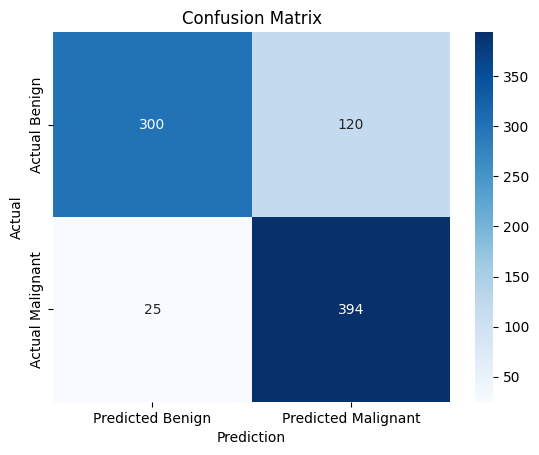

In [33]:
print("Accuracy:", best_svm.score(x_test_scaled_loaded, y_test_loaded))
print("Precision:", precision_score(y_test_loaded, y_pred, average='binary'))
print("Recall:", recall_score(y_test_loaded, y_pred, average='binary'))
print("F1 Score:", f1_score(y_test_loaded, y_pred, average='binary'))

print("\nClassification Report:")
print(classification_report(
    y_test_loaded,
    y_pred,
    target_names=['Benign', 'Malignant'] # [lành tính 0, ác tính 1]
))


cm = confusion_matrix(y_test_loaded, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted Benign', 'Predicted Malignant'],
    yticklabels=['Actual Benign', 'Actual Malignant']
)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


LƯU MODEL

In [34]:
joblib.dump(best_svm, "../model/svm_binary_class_model.joblib")

['../model/svm_binary_class_model.joblib']

ROC CURVE & AUC

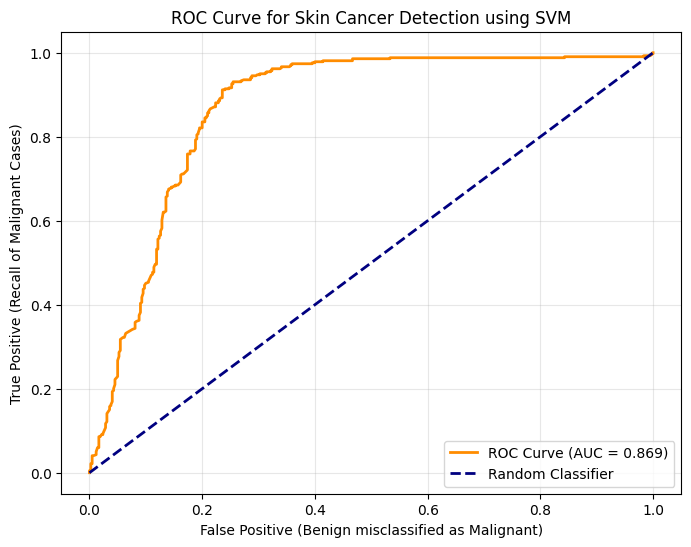

AUC : 0.8686


In [35]:
fpr, tpr, _ = roc_curve(y_test_loaded, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(
    fpr, tpr,
    color='darkorange',
    lw=2,
    label='ROC Curve (AUC = %0.3f)' % roc_auc
)

# đường đoán ngẫu nhiên
plt.plot([0, 1], [0, 1],
         color='navy',
         lw=2,
         linestyle='--',
         label='Random Classifier')

plt.xlabel('False Positive (Benign misclassified as Malignant)')
plt.ylabel('True Positive (Recall of Malignant Cases)')
plt.title('ROC Curve for Skin Cancer Detection using SVM')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"AUC : {roc_auc:.4f}")


Trục X (FP): Tỷ lệ lành tính bị dự đoán nhầm thành ác tính

Trục Y (TP / Recall): Tỷ lệ ung thư (ác tính) được phát hiện đúng => nên ưu tiên

AUC = 0.869 => chấp nhận ~14% ca lành tính bị nghi ngờ, ta đã phát hiện được ~86% ca ác tính

VISUALIZE BẰNG PCA

In [36]:
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        cmap='coolwarm',
        edgecolor='k',
        label='Skin Lesion Samples'
    )

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('SVM Decision Boundary for Skin Cancer Detection (PCA 2D)')
    plt.legend()
    plt.show()



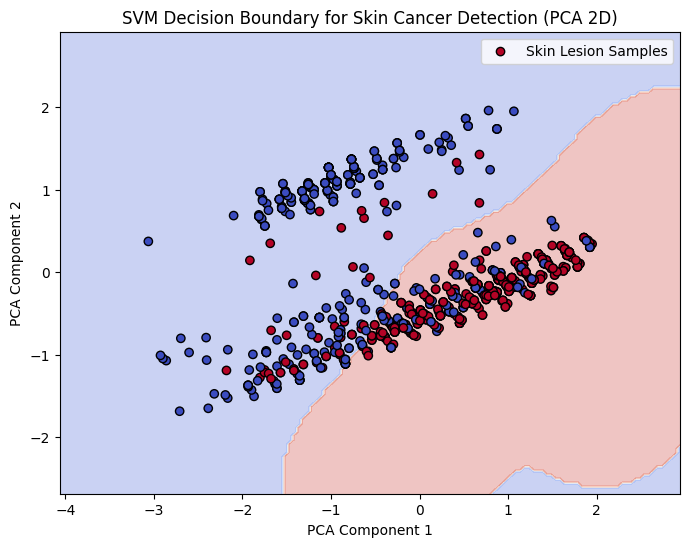

In [37]:
pca = PCA(n_components=2, random_state=seed)
x_train_pca = pca.fit_transform(x_train_scaled_loaded)
x_test_pca  = pca.transform(x_test_scaled_loaded)

# Huấn luyện lại SVM trên không gian PCA (chỉ để visualize)
best_svm.fit(x_train_pca, y_train_loaded)

# Vẽ decision boundary trên dữ liệu test (PCA)
plot_decision_boundary(x_test_pca, y_test_loaded, best_svm)